##### Задание:
In this competition your task will be to predict if a tutor is a proper one for preparing for the math exam.   

You can only use these imports:  

import numpy as np  
import pandas as pd   
from sklearn.model_selection import train_test_split   
import matplotlib.pyplot as plt   
import seaborn as sns  

In [1]:
import numpy as np  
import pandas as pd   
from sklearn.model_selection import train_test_split   
import matplotlib.pyplot as plt   
import seaborn as sns  
import random

##### Библиотеки

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [4]:
def get_bootstrap(data, labels, N, max_samples):
    n_samples = int(data.shape[0]*max_samples)
    bootstrap = []
    
    for i in range(N):
        #print(f'Build bootstrap {i}')
        b_data = np.zeros((n_samples, data.shape[1]))
        b_labels = np.zeros(n_samples)
        
        for j in range(n_samples):
            #sample_indexes = [i for i in range(n_samples-1)]
            ##df = pd.DataFrame(sample_indexes)
            ##sample_index = df.sample(n=1).values[0][0]
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    #df = pd.DataFrame(sample_indexes)
    #for _ in df[0].sample(n=len_subsample, random_state=1):
        
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет критерия Шеннона
import math

def Shennon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy= 1
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * math.log(p,2) 
    
    return entropy
        
def current_crit(labels, default_crit = 'Gini'):
    if default_crit == 'Shennon':
        return Shennon(labels)
    else:
        return  gini(labels)

In [7]:
def quality(left_labels, right_labels, current_value):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_value - p * current_crit(left_labels) - (1 - p) * current_crit(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_value = current_crit(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_value)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, current_depth=0):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or current_depth>=max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, current_depth + 1)
    false_branch = build_tree(false_data, false_labels, current_depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
import time
def random_forest(data, labels, n_trees, max_depth = 1, max_samples = 1):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees, max_samples)
    i_tree = 0
    start_time = time.time()
    epoch_time = start_time
    for b_data, b_labels in bootstrap:
        i_tree += 1
        forest.append(build_tree(b_data, b_labels, max_depth))
        if i_tree % 3 == 1:
            print(f'Build tree {i_tree} {(time.time() - epoch_time)}')
            epoch_time = time.time()
            
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
def ROC_AUC_metric(actual_, predicted_):
    actual, predicted = actual_.copy(), predicted_.copy()
    df = pd.DataFrame(data  = {'predicted': predicted, 'actual': actual})
    df.sort_values(by=['actual'])
    AUC = 0
    TPR = 0
    FPR = 0
    TP=FP=TN=FN = 0
    df_true = df.loc[df['predicted'] == df['actual'], 'predicted' ]
    df_false = df.loc[df['predicted'] != df['actual'], 'predicted' ]
    TP = df_true.sum()
    TN = df_true.count() - TP
    FP = df_false.sum()
    FN = df_false.count() - FP  
    TPR = TP/(TP+FN)
    FPR = FP/(TN+FP)
    AUC = (1 + TPR- FPR)/2
    return AUC

In [16]:
def info_dataset(df, name_dataset):
    spam = ''
    print(f'Dataset:{name_dataset}')
    print(f'Название {spam:21}|Всего |Null-значений |Уникальных значений |Тип')
    for column_name in df.columns:
        all_count =  len(df[column_name])
        null_count = sum(df[column_name].isnull())
        unique_count = df[column_name].unique().size
        print(f'{column_name:30}|{all_count:6}|{null_count:14}|{unique_count:20}|{df[column_name].dtype}')
    print('-'*100)

##### Data import

In [17]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TARGET_NAME = 'choose'
ALL_FEATURES = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 
               'biology', 'english', 'geography', 'history', 'mean_exam_points']


train = pd.read_csv(TRAIN_DATASET_PATH, index_col = 'Id')
test = pd.read_csv(TEST_DATASET_PATH, index_col = 'Id')

In [18]:
info_dataset(train, 'train')

Dataset:train
Название                      |Всего |Null-значений |Уникальных значений |Тип
age                           | 10000|             0|                  46|float64
years_of_experience           | 10000|             0|                  10|float64
lesson_price                  | 10000|             0|                  71|float64
qualification                 | 10000|             0|                   4|float64
physics                       | 10000|             0|                   2|float64
chemistry                     | 10000|             0|                   2|float64
biology                       | 10000|             0|                   2|float64
english                       | 10000|             0|                   2|float64
geography                     | 10000|             0|                   2|float64
history                       | 10000|             0|                   2|float64
mean_exam_points              | 10000|             0|                  68|float64
choose

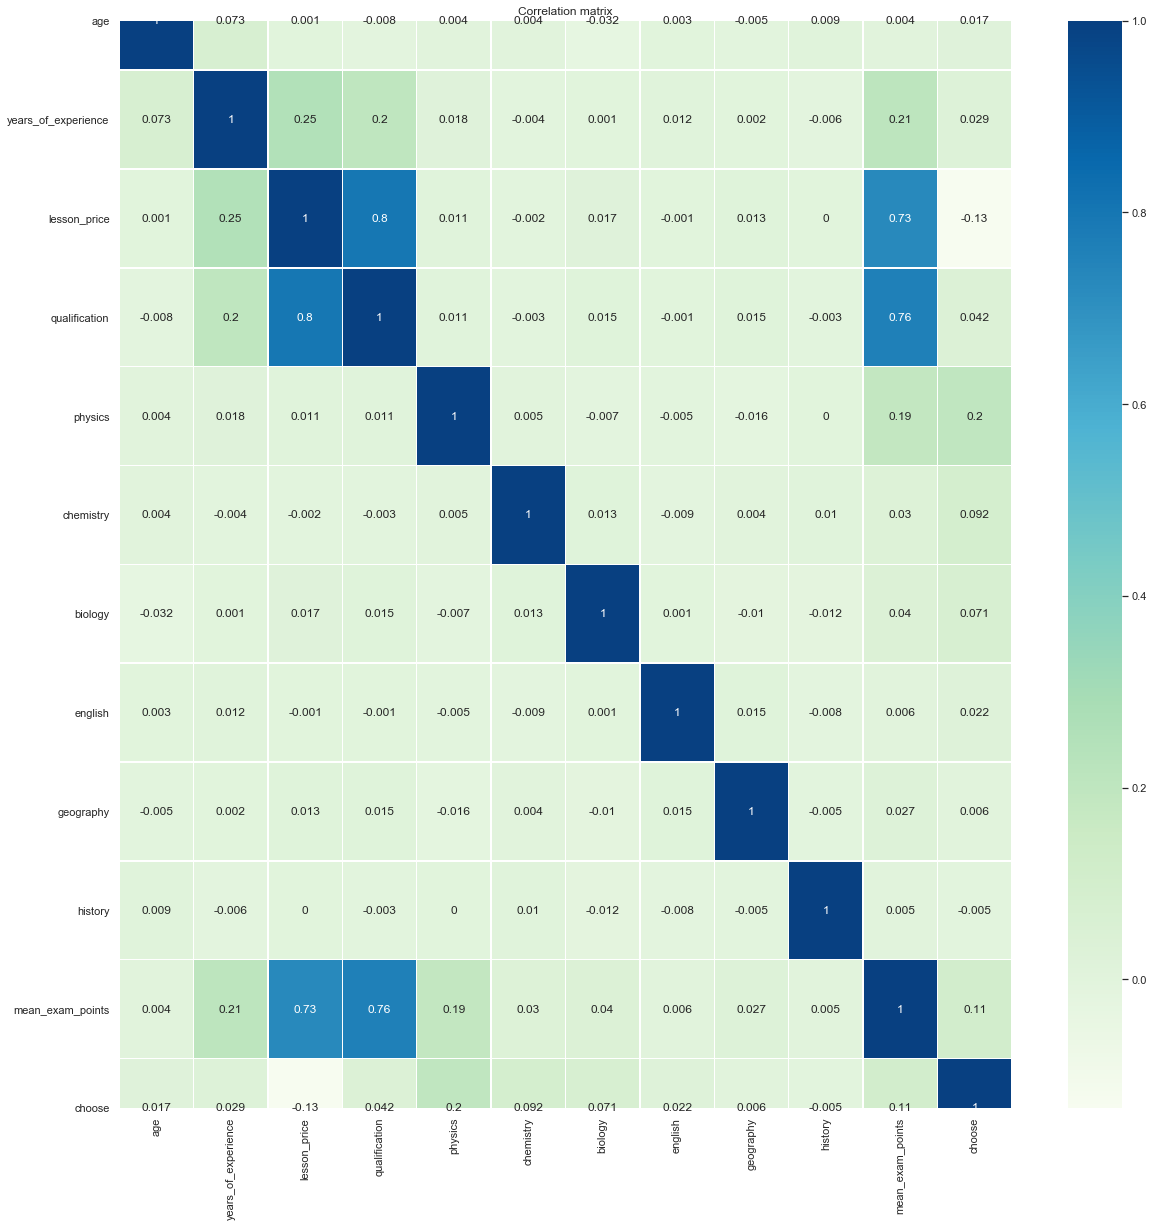

In [19]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1)
sns.heatmap(train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [20]:
ALL_FEATURES = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']

In [21]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection
X = train[ALL_FEATURES]
Y = train[TARGET_NAME]
train_data, valid_data, train_labels, valid_labels = model_selection.train_test_split(X, 
                                                                                     Y, 
                                                                                     stratify=Y,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [22]:
df_for_balancing = pd.concat([train_data,train_labels], axis=1)
df_for_balancing.groupby(TARGET_NAME).count()

,age,years_of_experience,lesson_price,qualification,mean_exam_points
choose,,,,,
0,6224,6224,6224,6224,6224
1,776,776,776,776,776


In [23]:
num_0 = len(df_for_balancing[df_for_balancing[TARGET_NAME]==0])
num_1 = len(df_for_balancing[df_for_balancing[TARGET_NAME]==1])
df_for_balanced = pd.concat([ df_for_balancing[df_for_balancing[TARGET_NAME]==0],
                              df_for_balancing[df_for_balancing[TARGET_NAME]==1].sample(int(num_0), replace=True)], axis=0)#
df_for_balanced = df_for_balanced.sample(frac=1).reset_index(drop=True)
df_for_balanced.groupby(TARGET_NAME).count()

,age,years_of_experience,lesson_price,qualification,mean_exam_points
choose,,,,,
0,6224,6224,6224,6224,6224
1,6224,6224,6224,6224,6224


In [24]:
df_for_balanced.describe()

,age,years_of_experience,lesson_price,qualification,mean_exam_points,choose
count,12448.000000,12448.000000,12448.000000,12448.000000,12448.00000,12448.00000
mean,45.866244,2.025868,1617.167416,1.771289,66.48080,0.50000
std,8.083333,1.819078,514.298355,0.833049,13.02793,0.50002
min,23.000000,0.000000,200.000000,1.000000,33.00000,0.00000
25%,40.000000,0.000000,1250.000000,1.000000,57.00000,0.00000
50%,46.000000,2.000000,1450.000000,2.000000,65.00000,0.50000
75%,51.000000,3.000000,2050.000000,2.000000,75.00000,1.00000
max,68.000000,9.000000,3750.000000,4.000000,100.00000,1.00000


In [25]:
train_data.describe()

,age,years_of_experience,lesson_price,qualification,mean_exam_points
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,45.797286,1.967000,1698.907143,1.724714,64.433000
std,8.033411,1.773718,524.676012,0.800818,13.592715
min,23.000000,0.000000,200.000000,1.000000,33.000000
25%,40.000000,0.000000,1300.000000,1.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,74.000000
max,68.000000,9.000000,3750.000000,4.000000,100.000000


In [26]:
train_data, train_labels = df_for_balanced[ALL_FEATURES], df_for_balanced[TARGET_NAME]
train_data.describe()

,age,years_of_experience,lesson_price,qualification,mean_exam_points
count,12448.000000,12448.000000,12448.000000,12448.000000,12448.00000
mean,45.866244,2.025868,1617.167416,1.771289,66.48080
std,8.083333,1.819078,514.298355,0.833049,13.02793
min,23.000000,0.000000,200.000000,1.000000,33.00000
25%,40.000000,0.000000,1250.000000,1.000000,57.00000
50%,46.000000,2.000000,1450.000000,2.000000,65.00000
75%,51.000000,3.000000,2050.000000,2.000000,75.00000
max,68.000000,9.000000,3750.000000,4.000000,100.00000


In [27]:
n_trees = 1

forest = random_forest(train_data.values,  train_labels.values.reshape(-1), n_trees, max_depth = 9, max_samples = 1)

Build tree 1 399.4907786846161


In [28]:
predicted = tree_vote(forest, train_data.values)

In [29]:
ROC_AUC_metric(train_labels.values.reshape(-1), predicted)

0.8737146529562982

In [30]:
predicted = tree_vote(forest, valid_data.values)

In [31]:
ROC_AUC_metric(valid_labels.values.reshape(-1), predicted)

0.6489779993717002

In [32]:
0.6411985663954168

0.6411985663954168

In [33]:
predicted_test = tree_vote(forest, test.values)

In [34]:
matrix = np.vstack((range(10000, 20000), predicted_test)).T
final_df = pd.DataFrame(matrix, index=range(matrix.shape[0]),
                          columns=range(matrix.shape[1]))
final_df.columns = ['Id', 'choose']
final_df['Id'] = final_df['Id'].astype('int')
final_df['choose'] = final_df['choose'].astype('int')
final_df.to_csv('result.csv', index=False)
